                                   Este trabalho foi apresentado como requisito parcial da 
                                   disciplina de Deep Learning e Redes Neurais do curso de 
                                   Inteligência Artificial da turma 2021-1 do Instituto de 
                                   Ensino Superior de Brasília (IESB)

# Atividade 2: Classificação de imagens na base de dados CIFAR-10 com CNN e Data Augmentation

> # Descrição do Dataset CIFAR-10
> O dataset CIFAR-10 consiste de 60 mil imagens coloridas, com 10 classes distintas igualmente balanceadas (isto é, 6 mil imagens por classe).
> O conjunto é separado em 50 mil imagens para treinamento e 10 mil para teste.
> As imagens são de animais e objetos, com as seguintes classes:
>  - 0 - Avião										
>  - 1 - Automóvel
>  - 2 - Pássaro
>  - 3 - Gato
>  - 4 - Cervo
>  - 5 - Cachorro
>  - 6 - Sapo
>  - 7 - Cavalo
>  - 8 - Barco
>  - 9 - Caminhão
>Fonte: https://www.cs.toronto.edu/~kriz/cifar.html

## Preparação

### Carrega as libs

In [1]:
#start_hidden

print( 'Carregando bibliotecas principais...')

import sys
#!pip install tensorflow==2.6.0
#!pip install seaborn
#!pip install matplotlib 
#!pip install seaborn
#!pip install scipy 
#!pip install sklearn

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import itertools

print( 'Carregando bibliotecas principais... ok')

strategy = tf.distribute.MirroredStrategy() 
print( "Placas aceleradoras a disposição: ", strategy.num_replicas_in_sync)


Carregando bibliotecas principais...
Carregando bibliotecas principais... ok
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Placas aceleradoras a disposição:  1


2021-10-06 11:24:38.545073: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-06 11:24:39.324756: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-06 11:24:39.328457: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-06 11:24:39.333005: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

# Parte A

## Dataset

Enunciado:
>  - Carregue o dataset.
> ```python
> from tensorflow.keras.datasets import cifar10
> (X_train, y_train), (X_test, y_test) = cifar10.load_data()
> ```
> - Escolha, aletoriamente (e de forma automatizada), 16 imagens na base de treino, e apresente-as visualmente em um gráfico 4x4 (subplot).
> - Verifique se as dimensões dos tensores estão de acordo com a descrição do dataset.
> - Realize, caso necessário, pré-processamento nos dados. (Ex: normalização, padronização, codificação de classes, etc).

### Carga do dataset

In [2]:
#start_hidden

def bloco():

    global X_train, y_train, X_test, y_test
    global class_names

    from tensorflow.keras.datasets import cifar10

    class_names = [
      'Avião', 'Automóvel', 'Pássaro', 'Gato', 'Veado',
      'Cachorro', 'Sapo', 'Cavalo', 'Navio', 'Caminhão'
    ]

    (X_train, y_train), (X_test, y_test) = cifar10.load_data()

    # simpifica o conjunto de labels
    y_train = y_train.flatten()
    y_test = y_test.flatten()
    
    print( f'Dataset carregado...' )   
    print( f'Shape dos dados: X={X_train.shape} y={y_train.shape}')      


    #print( 'Convertendo para escala de cinza... treino...')
    #X_train = np.array( [ X_train[i,:,:,0]*0.299 + X_train[i,:,:,1]*0.587 + X_train[i,:,:,2]*0.114 for i in range(len(X_train))] )
    #print( 'Convertendo para escala de cinza... teste...')
    #X_test = np.array( [ X_test[i,:,:,0]*0.299 + X_test[i,:,:,1]*0.587 + X_test[i,:,:,2]*0.114 for i in range(len(X_test))] )
    #print( 'Convertendo para escala de cinza... OK!')

    X_train = X_train.reshape((-1,32,32,3))
    X_test = X_test.reshape((-1,32,32,3))

    print( f'Shape dos dados: X={X_train.shape} y={y_train.shape}')      




bloco()

Dataset carregado...
Shape dos dados: X=(50000, 32, 32, 3) y=(50000,)
Shape dos dados: X=(50000, 32, 32, 3) y=(50000,)


### Dados básicos

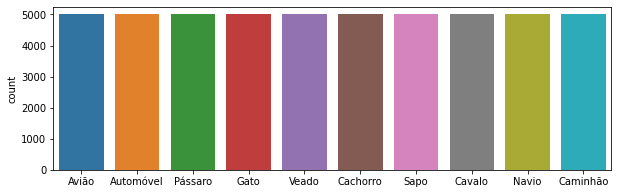

In [3]:
#start_hidden
def bloco():
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10,3))
    p = sns.countplot(x=y_train.flatten())
    p.set(xticklabels=class_names)

bloco()

### Amostra das imagens importadas

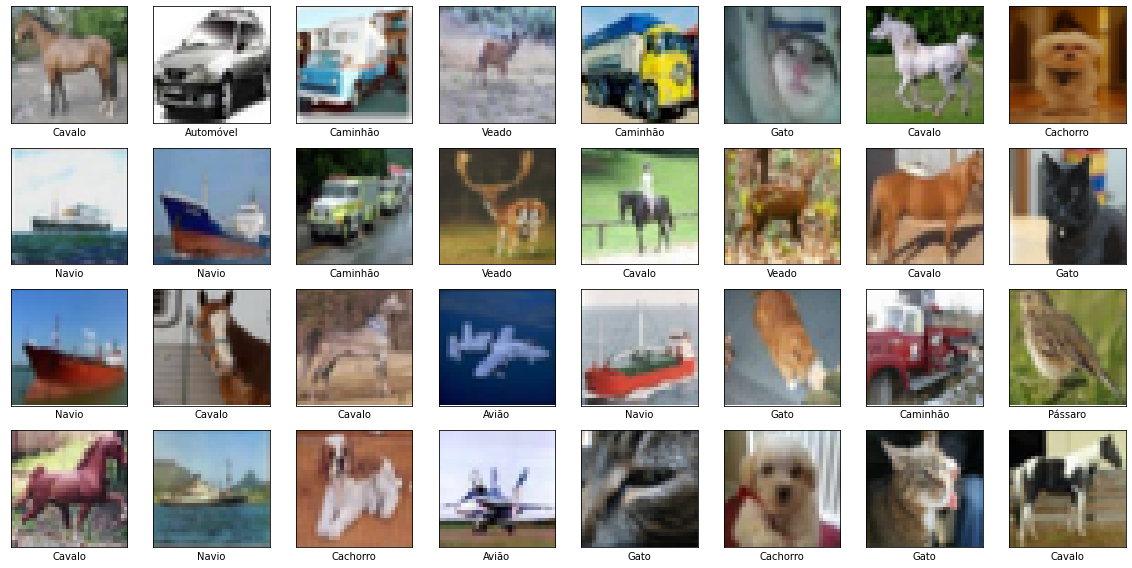

In [4]:
#start_hidden
def bloco():
    import matplotlib.pyplot as plt
    import random as rnd
  
    szx = 8
    szy = 4
    fig, axs = plt.subplots( szy,szx, figsize=[szx*2,szy*2] )
    axs = axs.flatten()
    for ax in axs:
      r = rnd.randint( 0, len( X_train ) )
      ax.set_xticks( [] )
      ax.set_yticks( [] )
      ax.grid( False )
      ax.imshow( X_train[r], cmap=plt.cm.binary )
      ax.set_xlabel( class_names[ y_train.flatten()[ r ] ] )

    plt.tight_layout()
    plt.show()

bloco()

### Pré-processamentos

Para os pré-processamentos, foram aplicadas as seguintes transformações:
* one-hot na classe (valores categóricos são convertidos em colunas)
* cor do pixel de 0 à 255 para 0.0 a 1.0
* reestruturação do shape 


In [5]:
#start_hidden

def bloco():
    import numpy as np
    
    global X_train, y_train, X_test, y_test
        
    # converte a entrada para um tensor único de 50.000x32x32x1
    #X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
    #X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
    
    # normaliza os pixels para valores de 0 a 1 no lugar de 0 a 255
    X_train = X_train / 255.0
    X_test = X_test / 255.0
    
    # aplica a codificação one_hot para as classes, ou seja:
    #    1 - 0 0 0 0 0 0 1
    #    2 - 0 0 0 0 0 1 0
    #    3 - 0 0 0 0 1 0 0
    #    (...) cada valor distinto vira uma coluna com 0 ou 1.
    y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
    y_test = tf.one_hot(y_test.astype(np.int32), depth=10)
    
    print( f'Efetuados pré-processamentos básicos...' )
    print( f'Shape dos dados: X={X_train.shape} y={y_train.shape}')      

bloco()


Efetuados pré-processamentos básicos...
Shape dos dados: X=(50000, 32, 32, 3) y=(50000, 10)


## Implementação do Modelo CNN

### Arquitetura

Enunciado:
> - Defina uma função que implemente uma arquitera de Rede Convolucional (utilizando o Keras) e retorne um objeto desse seu modelo. 
> - A escolha de parâmetros do modelo, como, por exemplo, *quantidade de camadas convolucionais*, *quantidade de filtros em cada cada camada convolucional*, *quantidade de camadas densas*,  *funções de ativação*, fica a critério do projetista. 
> - Instancie um modelo usando a função implementada, e apresente um resumo da arquitetura.

In [6]:
#start_hidden

def bloco():

    global model

    tf.random.set_seed( 1829738 )
    
    mp_num_classes = len(class_names)

    model = tf.keras.models.Sequential([    
        tf.keras.layers.Conv2D( filters=100, kernel_size=(3,3), strides=(2,2), activation='relu', padding='valid', input_shape=(32,32,3) ),
        tf.keras.layers.Dropout(0.25),        
        tf.keras.layers.Conv2D( filters=200, kernel_size=(5,5), strides=(2,2), activation='relu', padding='valid' ),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D( filters=100, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid' ),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(mp_num_classes, activation='softmax')
    ])

    model.summary()

bloco()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 15, 15, 100)       2800      
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 100)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 200)         500200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 200)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 100)         180100    
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 100)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0

### Compilação

> - Baseado no problema descrito, defina a função custo que será otimizada, e qual otimizador será utilizado.
> - Defina também quais métricas serão avaliadas pelo modelo durante a etapa de treinamento e de validação.


In [7]:
#start_hidden
def bloco():

    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(
            learning_rate=0.0001, 
            decay=1e-06
        ),    
        loss='categorical_crossentropy', 
        metrics=['acc']
    )
    
    print( 'OK, modelo compilado...' )
    
bloco()

OK, modelo compilado...



### Treinamento e Validação 
 
> - Defina a quantidade máxima de épocas para o treinamento.
> - Utilize alguma rotina de *callback* para que o treinamento não dure o máximo de épocas definido, caso isso não seja necessário.
> - Utilize 20% da base de treino para validar o modelo a cada época.  <br>
> - Mostre em um gráfico o comportamento da função custo (*loss*) e da acurácia, ao longo das epócas, para as bases de treino e de validação.

In [8]:
#start_hidden
def bloco():
    
    global history
    
    my_callbacks = [
        # abandona o processamento se a acurácia não melhorar em até {patitence} épocas
        tf.keras.callbacks.EarlyStopping(monitor='val_acc',patience=6), 
        # grava os modelos intermediários
        tf.keras.callbacks.ModelCheckpoint(filepath='model/model.{epoch:02d}.h5'), # salva o modelo para poder retomar o treinamento
        # grava informações para visualização
        # tf.keras.callbacks.TensorBoard(log_dir='./logs'), 
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, min_lr=0.00001)
    ]

    history = model.fit(
        X_train, 
        y_train, 
        batch_size=20,
        epochs=40,
        callbacks=my_callbacks,
        validation_split=0.2
    )
    
    print( 'OK, modelo treinado')
       
bloco()

2021-10-06 11:25:50.324225: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 491520000 exceeds 10% of free system memory.
2021-10-06 11:25:51.037422: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 491520000 exceeds 10% of free system memory.
2021-10-06 11:25:51.425625: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2021-10-06 11:25:53.350717: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8202


2000/2000 [==============================] - 53s 24ms/step - loss: 1.9559 - acc: 0.2771 - val_loss: 1.6788 - val_acc: 0.3967
Epoch 2/40
2000/2000 [==============================] - 41s 20ms/step - loss: 1.6347 - acc: 0.4060 - val_loss: 1.4621 - val_acc: 0.4719
Epoch 3/40
2000/2000 [==============================] - 44s 22ms/step - loss: 1.4827 - acc: 0.4660 - val_loss: 1.3915 - val_acc: 0.5082
Epoch 4/40
2000/2000 [==============================] - 45s 22ms/step - loss: 1.3875 - acc: 0.5014 - val_loss: 1.2716 - val_acc: 0.5547
Epoch 5/40
2000/2000 [==============================] - 43s 21ms/step - loss: 1.3091 - acc: 0.5350 - val_loss: 1.2088 - val_acc: 0.5762
Epoch 6/40
2000/2000 [==============================] - 48s 24ms/step - loss: 1.2377 - acc: 0.5612 - val_loss: 1.1647 - val_acc: 0.5838
Epoch 7/40
2000/2000 [==============================] - 50s 25ms/step - loss: 1.1811 - acc: 0.5839 - val_loss: 1.0951 - val_acc: 0.6180
Epoch 8/40
2000/2000 [==============================] - 52s

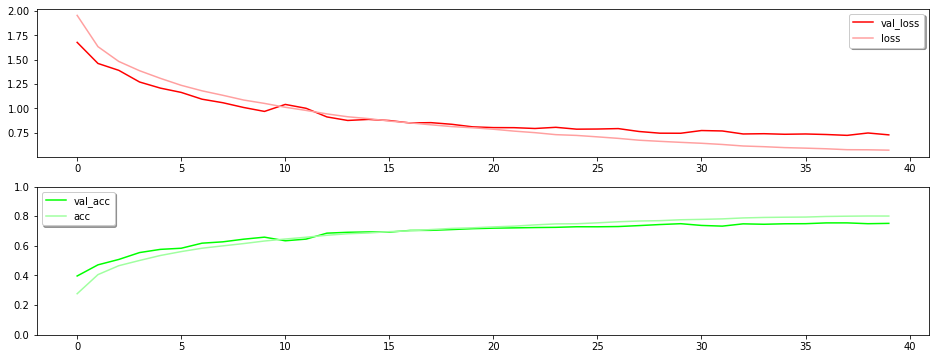

In [9]:
def bloco():
    
    fig, ax = plt.subplots(2,1,figsize=(16,6))
    ax[0].plot(history.history['val_loss'], color='#FF0000', label="val_loss")
    ax[0].plot(history.history['loss'], color='#FFA0A0', label="loss")
    legend = ax[0].legend(loc='best', shadow=True)
        
    ax[1].plot(history.history['val_acc'], color='#00FF00', label="val_acc")
    ax[1].plot(history.history['acc'], color='#A0FFA0', label="acc")
    ax[1].set_ylim([0.0,1.0])
    legend = ax[1].legend(loc='best', shadow=True)        
    
bloco()

In [10]:
def bloco():
    
    print( 'Seleciona o modelo com maior acurácia durante a validação (usualmente antes do overfit)' )
    
    best_acc = max(history.history['val_acc'])
    best_epoch = history.history['val_acc'].index(best_acc) + 1
    
    print( f'melhor epoca: {best_epoch} val_acc={best_acc:1.2f}' )    
        
    model.load_weights( f'model/model.{best_epoch:02d}.h5' )

bloco()

Seleciona o modelo com maior acurácia durante a validação (usualmente antes do overfit)
melhor epoca: 38 val_acc=0.75


### Desempenho na Base de Teste

> - Realize, com o modelo treinado, predições na base de teste (método *predict*).
>  - Com as predições, calcule a precisão e a revocação para cada classe.  <br>
   (Pode ser utilizada a função *classification_report* do *scikit-learn* ou alguma outra similar).

              precision    recall  f1-score   support

       Avião       0.81      0.79      0.80      1000
   Automóvel       0.85      0.84      0.85      1000
     Pássaro       0.68      0.62      0.65      1000
        Gato       0.59      0.56      0.57      1000
       Veado       0.66      0.72      0.69      1000
    Cachorro       0.65      0.62      0.64      1000
        Sapo       0.78      0.85      0.81      1000
      Cavalo       0.81      0.77      0.79      1000
       Navio       0.85      0.86      0.85      1000
    Caminhão       0.79      0.86      0.82      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



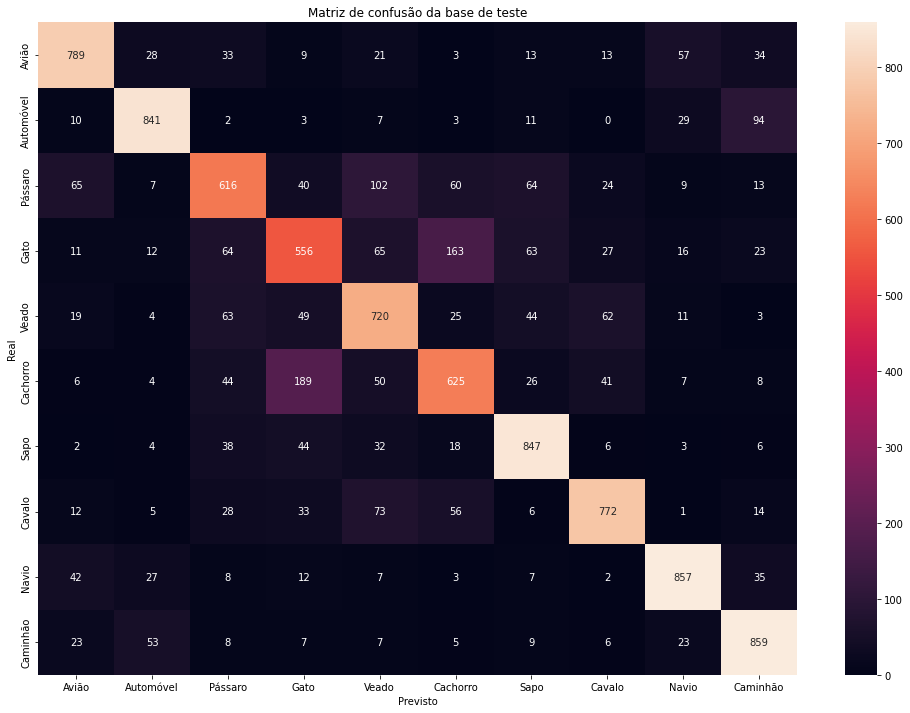

In [11]:
#start_hidden
def bloco():

    from sklearn.metrics import classification_report

    #test_loss, test_acc = model.evaluate(X_test, y_test)

    # Predict the values from the validation dataset
    y_pred = model.predict(X_test)
    # Convert predictions classes to one hot vectors 
    y_pred_classes = np.argmax(y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    y_true = np.argmax(y_test,axis = 1)
    # compute the confusion matrix
    confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_classes)

    print( classification_report( y_true, y_pred_classes, target_names=class_names ) )   

    plt.figure(figsize=(17, 12))
    c = sns.heatmap(confusion_mtx, annot=True, fmt='g')
    c.set(xticklabels=class_names, yticklabels=class_names)
    c.set_xlabel('Previsto')
    c.set_ylabel('Real')
    c.set_title('Matriz de confusão da base de teste')

bloco()

# Parte B: Data Augmentation

## Recarregue o Dataset CIFAR-10

> - Recarregue o dataset CIFAR-10, conforme feito na parte A, porém sem realizar pré-processamentos.
> - Utilize a classe **ImageDataGenerator** do Keras para fazer os pré-processamentos adequados, e aplicar as transformações nas imagens, de forma a gerar novos exemplos para o treinamento (*data augmentation*). A escolha das transformações é livre ao projetista.
> - Mostre em um gráfico 4x4 (subplot), 16 exemplos aleatórios dessas imagens transformadas, com seus respectivos rótulos.
> - Configure 20% dos dados para validação. Isso deve ser feito durante o instanciamento do objeto que irá manipular o dataset.
> - Obs: Aplique as transformações apenas no conjunto de treino retornado pela função *cifar10.load_data()*. No conjunto de teste, apenas os pré-processamentos devem ser utilizados (não utilize *data augmentation* nessa base)

In [12]:
#start_hidden

def bloco():

    global X_train, y_train, X_test, y_test, X_test2, y_train2 
    global class_names

    from tensorflow.keras.datasets import cifar10

    class_names = [
      'Avião', 'Automóvel', 'Pássaro', 'Gato', 'Veado',
      'Cachorro', 'Sapo', 'Cavalo', 'Navio', 'Caminhão'
    ]

    (X_train, y_train), (X_test, y_test) = cifar10.load_data()

    # simpifica o conjunto de labels
    y_train = y_train.flatten()
    y_test = y_test.flatten()
    
    print( f'Dados importados' )
    print( f'Shape dos dados: X={X_train.shape} y={y_train.shape}')      

bloco()

Dados importados
Shape dos dados: X=(50000, 32, 32, 3) y=(50000,)


In [13]:
#start_hidden

def bloco():
    
    import numpy as np
    
    global X_train, y_train, X_test, y_test, y_test2, y_train2
        
    # converte a entrada para um tensor único de 50.000x32x32x3
    #X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 3)
    #X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 3)
    
    # normaliza os pixels para valores de 0 a 1 no lugar de 0 a 255
    X_train = X_train / 255.0
    X_test = X_test / 255.0
     
    # aplica a codificação one_hot para as classes, ou seja:
    #    1 - 0 0 0 0 0 0 1
    #    2 - 0 0 0 0 0 1 0
    #    3 - 0 0 0 0 1 0 0
    #    (...) cada valor distinto vira uma coluna com 0 ou 1.
    y_train2 = tf.one_hot(y_train.astype(np.int32), depth=10)
    y_test2 = tf.one_hot(y_test.astype(np.int32), depth=10)
       
    print( f'Dados processados' )    
    print( f'Shape dos dados: X={X_train.shape} y={y_train.shape}')      

bloco()

Dados processados
Shape dos dados: X=(50000, 32, 32, 3) y=(50000,)


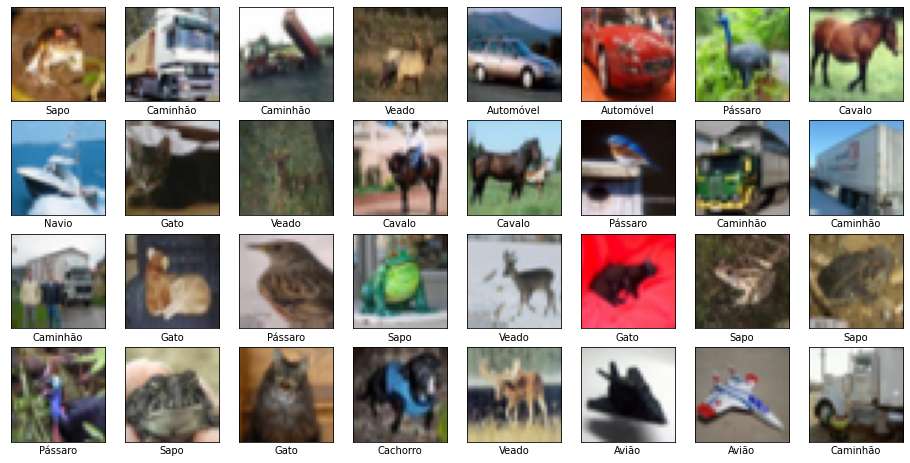

In [14]:
#start_hidden

def bloco():
      
    global datagen                
        
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(          
        #featurewise_center=True,
        #featurewise_std_normalization=True,
        #rotation_range=5,
        shear_range=2,
        width_shift_range=2,  # ex: 2 = [-1, 0 ou +1]
        height_shift_range=2, # ex: 2 = [-1, 0 ou +1]
        horizontal_flip=True,
        validation_split=0.2,
        #zoom_range=0.05,
        #fill_mode='wrap'
    )
    
    datagen.fit( X_train[1:1000] )
        
    for X_temp, y_temp in datagen.flow( x=X_train, y=y_train, batch_size=50, shuffle=False, seed=21398712 ):        
    
        import matplotlib.pyplot as plt
        import random as rnd

        szx = 8
        szy = 4
        fig, axs = plt.subplots( szy,szx, figsize=[szx*2,szy*2] )
        axs = axs.flatten()
        for i, ax in enumerate(axs):
          #r = rnd.randint( 0, len( X_temp )-1 )
          r = i
          ax.set_xticks( [] )
          ax.set_yticks( [] )
          ax.grid( False )
          ax.imshow( ( X_temp[r] * 255 ).astype(np.uint8), cmap=plt.cm.binary )
          ax.set_xlabel( class_names[ y_temp.flatten()[ r ] ] )
              
        break;
        
bloco()

## Retreine o seu modelo

### Compilação e Treinamento

> - Utilizando a mesma função definida na parte A, instancie um novo modelo.
> - Com os mesmos critérios, treine esse novo modelo utilizando para treino e validação os objetos definidos pelo *ImageDataGenerator*.
> - Mostre em um gráfico o comportamento da função custo (loss) e da acurácia, ao longo das epócas, para as bases de treino e de validação.


### Desempenho na Base de Teste

In [15]:
#start_hidden

def bloco():

    global model

    tf.random.set_seed( 1829738 )
    
    mp_num_classes = len(class_names)

    model = tf.keras.models.Sequential([    
        tf.keras.layers.Conv2D( filters=100, kernel_size=(3,3), strides=(2,2), activation='relu', padding='valid', input_shape=(32,32,3) ),
        tf.keras.layers.Dropout(0.25),        
        tf.keras.layers.Conv2D( filters=200, kernel_size=(5,5), strides=(2,2), activation='relu', padding='valid' ),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D( filters=100, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid' ),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(mp_num_classes, activation='softmax')
    ])

    model.summary()

bloco()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 15, 15, 100)       2800      
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 100)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 200)         500200    
_________________________________________________________________
dropout_5 (Dropout)          (None, 6, 6, 200)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 100)         180100    
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 4, 100)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)             

In [16]:
#start_hidden
def bloco():

    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(
            learning_rate=0.0001, 
            decay=1e-06
        ),    
        loss='categorical_crossentropy', 
        metrics=['acc']
    )
    
    print( 'OK, modelo compilado...' )
    
bloco()

OK, modelo compilado...


In [17]:
#start_hidden
def bloco():
    global history
    
    mp_epochs=50
    mp_batch_size=20

    my_callbacks = [
        # abandona o processamento se a acurácia não melhorar em até {patitence} épocas
        tf.keras.callbacks.EarlyStopping(monitor='val_acc',patience=6), 
        # grava os modelos intermediários
        tf.keras.callbacks.ModelCheckpoint(filepath='model/model.{epoch:02d}.h5'), # salva o modelo para poder retomar o treinamento
        # grava informações para visualização
        # tf.keras.callbacks.TensorBoard(log_dir='./logs'), 
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, min_lr=0.00001, verbose=True)
    ]
        
    history = model.fit(
        datagen.flow( x=X_train, y=y_train2, batch_size=mp_batch_size, subset='training', seed=1829738 ),
        batch_size=mp_batch_size,
        epochs=mp_epochs,
        steps_per_epoch=int(len(X_train)*0.8/mp_batch_size),
        callbacks=my_callbacks,
        validation_data=datagen.flow(X_train, y_train2, batch_size=8, subset='validation', seed=1829738 )
        #validation_data=(X_test,y_test2)
    )
    
    print( 'OK, modelo treinado')
    
   
bloco()

Epoch 1/50
2000/2000 [==============================] - 59s 29ms/step - loss: 1.9526 - acc: 0.2780 - val_loss: 1.6395 - val_acc: 0.4105
Epoch 2/50
2000/2000 [==============================] - 54s 27ms/step - loss: 1.6367 - acc: 0.4058 - val_loss: 1.5201 - val_acc: 0.4549
Epoch 3/50
2000/2000 [==============================] - 56s 28ms/step - loss: 1.4962 - acc: 0.4602 - val_loss: 1.3422 - val_acc: 0.5253
Epoch 4/50
2000/2000 [==============================] - 58s 29ms/step - loss: 1.3965 - acc: 0.5004 - val_loss: 1.2550 - val_acc: 0.5538
Epoch 5/50
2000/2000 [==============================] - 55s 28ms/step - loss: 1.3230 - acc: 0.5295 - val_loss: 1.2551 - val_acc: 0.5659
Epoch 6/50
2000/2000 [==============================] - 55s 27ms/step - loss: 1.2599 - acc: 0.5505 - val_loss: 1.1883 - val_acc: 0.5774
Epoch 7/50
2000/2000 [==============================] - 57s 28ms/step - loss: 1.2077 - acc: 0.5739 - val_loss: 1.0924 - val_acc: 0.6184
Epoch 8/50
2000/2000 [==========================

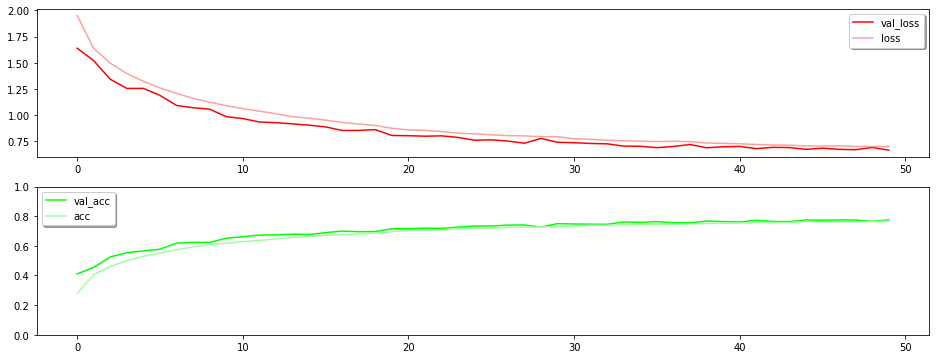

In [18]:
def bloco():
    
    fig, ax = plt.subplots(2,1,figsize=(16,6))
    ax[0].plot(history.history['val_loss'], color='#FF0000', label="val_loss")
    ax[0].plot(history.history['loss'], color='#FFA0A0', label="loss")
    legend = ax[0].legend(loc='best', shadow=True)
        
    ax[1].plot(history.history['val_acc'], color='#00FF00', label="val_acc")
    ax[1].plot(history.history['acc'], color='#A0FFA0', label="acc")
    ax[1].set_ylim([0.0,1.0])
    legend = ax[1].legend(loc='best', shadow=True)        
    
bloco()

In [21]:
def bloco():
    
    print( 'Seleciona o modelo com maior acurácia durante a validação (usualmente antes do overfit)' )
    
    best_acc = max(history.history['val_acc'])
    best_epoch = history.history['val_acc'].index(best_acc) + 1
    
    print( f'melhor epoca: {best_epoch} val_acc={best_acc:1.2f}' )    
        
    model.load_weights( f'model/model.{best_epoch:02d}.h5' )

bloco()

Seleciona o modelo com maior acurácia durante a validação (usualmente antes do overfit)
melhor epoca: 50 val_acc=0.78


              precision    recall  f1-score   support

       Avião       0.81      0.81      0.81      1000
   Automóvel       0.91      0.85      0.88      1000
     Pássaro       0.73      0.63      0.68      1000
        Gato       0.68      0.52      0.59      1000
       Veado       0.70      0.76      0.73      1000
    Cachorro       0.69      0.68      0.69      1000
        Sapo       0.73      0.90      0.80      1000
      Cavalo       0.81      0.83      0.82      1000
       Navio       0.88      0.87      0.87      1000
    Caminhão       0.80      0.90      0.84      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



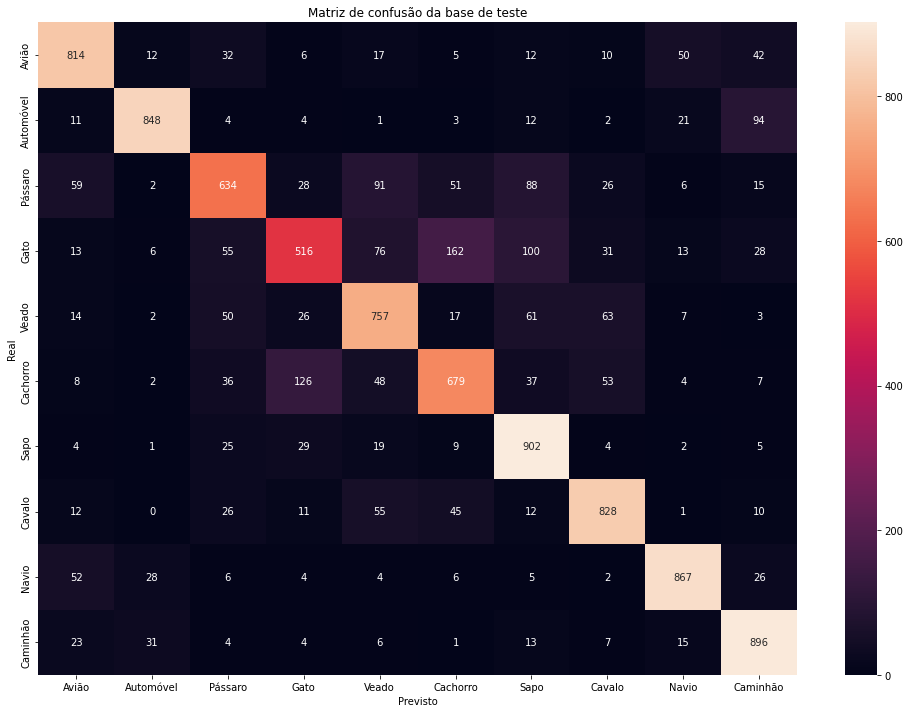

In [20]:
#start_hidden
def bloco():

    from sklearn.metrics import classification_report

    #test_loss, test_acc = model.evaluate(X_test, y_test)

    # Predict the values from the validation dataset
    y_pred = model.predict(X_test)
    # Convert predictions classes to one hot vectors 
    y_pred_classes = np.argmax(y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    y_true = np.argmax(y_test2,axis = 1)
    # compute the confusion matrix
    confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_classes)

    print( classification_report( y_true, y_pred_classes, target_names=class_names ) )   

    plt.figure(figsize=(17, 12))
    c = sns.heatmap(confusion_mtx, annot=True, fmt='g')
    c.set(xticklabels=class_names, yticklabels=class_names)
    c.set_xlabel('Previsto')
    c.set_ylabel('Real')
    c.set_title('Matriz de confusão da base de teste')

bloco()

# Considerações Finais

> Após o término do treinamento, calcule as mesmas métricas de desempenho descritas na parte A para a base de teste.
> Houve melhora no desempenho?

Nas primeiras tentativas de "image augumentation" houve piora sensível no modelo, mas acredito que isto aconteceu pois eu tentei umas transformações incluindo rotação, inclinação, zoom e deslocamento:

* Através da inspeção visual de amostra de imagens tranformadas, foi possível perceber uma queda sensível de qualidade ao usar filtros de zoom e rotação.

* Os filtros de rotação e zoom também aumentaram muito o tempo de processamento de algo em torno de 40 segundos por época para 5 minutos por época e isto também precisa ser levado em conta pois este tempo poderia ser usado para treinar redes neurais com maior densidade, mais convoluções ou mais camadas. 

* Os filtros de deslocamento, inclinação e espelhamento não adicionaram tempo relevante ao processamento. Faz sentido pois a implementação do image augumentation só precisará deslocar números na matriz sem fazer cálculos. 

É importante lembrar que o conjunto de dados CIFAR10 tem uma resolução muito baixa e quase toda transformação implica em alguma perda de informação. 

Em minha intuição, a técnica de image augumentation troca tempo de pré-processamento por uma probabilidade menor de overfit. Transformações como rotação e zoom, em especial seriam interessantes para dar mais flexibilidade ao modelo, mas exigiriam redes maiores e maior tempo de processamento, muito além do que eu posso experimentar em ambientes livres e em meu notebook que tem apenas uma Geforce MX940. Um nível alto de flexibilidade dependerá de hardware bem maior, possivelmente supercomputadores para formar as camadas de detecção de features mais genéricas.



No modelo em que alcançamos 75% de acurácia sem o image augumentation, alcançamos 77% de acurácia com o image augumentation. 

O que mais me chamou atenção foi uma menor diferença entre a acurácia da validação e a acurácia do treino quando utilizado o augumentation. 

Isto sugere que é mais difícil para o modelo desenvolver overfit. 
